# Expanding Nutri-Score : take your menu to the next level

### Abstract
The nutrition is a major issue in the Western civilization. The bad eating habits are becoming one of the main causes of illness in the world, with very heavy impact on public health. Recently, the various products are being graded through nutrition benefits indices, as for example Nutri-Score. 
Nutri-Score can give an accurate estimation on how healthy an ingredient can be. However, if it can make sense at the ingredient scale, the concept of Nutri-Score would be way more valuable if it were computed considering wider time spans instead of individual ingredients. Indeed, in its present version, Nutri-Score would always give a very high grade to white rice, for example. However, if you only eat white rice, your overall nutrition will not be optimal. The present computation of Nutri-Score is strongly limited, as it is unable to contextualize the consumption of a certain product in regard with the daily feeding practises.

### Millestone 2
During this millestone 2, we perform different task to understand our database what is inside and how to improve it. 
* First of all, we clean our database. The users that fill the database of OpenFoddFacts do errors so we have to detect and correct them.
* After that, we fill the database using nearest neighbourg that we compute ourself and suggest also different method to fill.
* After the filling, we are able to visualize our database.
* Finally, we perform our Nutri-Score algorithm using as reference <a href= "http://agriculture.gouv.fr/telecharger/87510?token=537276c9f22122955add7292abbcce0d">the document of the Ministry of Agriculture of France [in French].</a>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix

from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from computeNutriScore import computeNutriScore

import warnings
warnings.filterwarnings('ignore')

%run Data_scrapping_USagriculture.ipynb

DATA_FOLDER = './data/'

## OpenFoodFacts Dataset Exploration

In this millestone 2 , we will not using all the column that OpenFoodFacts provided to us, we will use :
* `code` : Barcode of the product
* `product_name` : Name of the product 
* `categories_tags` : Tags that describe the product into categories
* `energy_100g` : Amount of energy in the product [kJ] per 100g/100ml
* `fat_100g` : Amount of fats in the product [g] per 100g/100ml
* `saturated-fat_100g` : Amount of subacategories of fats (saturated-fat) in the product [g] per 100g/100ml
* `sugars_100g` : Amount of sugars in the product [g] per 100g/100ml
* `salt_100g` : Amount of salt in the product [g] per 100g/100ml
* `sodium_100g` : Amount of subcategories of salt (sodium) in the product [g] per 100g/100ml
* `fruits-vegetables-nuts_100g` : Ratio of Fruits/Vegetables/Nuts really inside the product [%] per 100g/100ml
* `fruits-vegetables-nuts-estimate_100g` : Ratio of Fruits/Vegetables/Nuts estimated inside the product [%] per 100g/100ml
* `fiber_100g` : Amount of fiber in the product [g] per 100g/100ml
* `proteins_100g` : Amount of protein in the product [g] per 100g/100ml
* `nutrition_grade_fr` : Grade of the product (provided by OpenFoodFacts)
* `nutrition-score-fr_100g` : Score of the product (provided by OpenFoodFacts)

### Loading & Cleaning

We use <a href = "https://fr.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv">the database provided by OpenFoodFacts</a> (31.10.2018). 

In [2]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

First of all, we delete the duplicates according to the barcode of the product. Indeed, it is logical that two product do not have the same barcode. We do not keep one duplicate because we can not decide wich one is correct. All of our algorithms use `categories_tags` to categories a product, so we clean also all the product where the user gave no tags. There are several categories_tags that OpenFoodFacts provided (`categories`, `categories_tags`, `categories_fr`) but we decide to keep `categories_tags` because it seems that the users fill more this information.

In [3]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)


We will use a more condens of the database (`data_food`) because we do not need the other informations yet.

In [4]:
data_food.head()

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0000000001281,Tarte noix de coco,"en:pies,en:sweet-pies,en:coconut-pies",1594.0,22.0,15.5,21.9,0.100,0.039370,NaN,NaN,4.4,4.6
0000000001885,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",657.0,0.0,0.0,27.0,0.000,0.000000,NaN,NaN,3.6,0.6
0000000005470,BAguette bressan,"en:plant-based-foods-and-beverages,en:plant-ba...",669.0,2.2,0.5,0.6,0.358,0.140945,NaN,NaN,1.6,9.5
0000000005661,Pavé de saumon fumé à la ficelle,"en:seafood,en:fishes,en:salmons,en:smoked-fish...",1059.0,17.0,2.6,0.5,2.500,0.984252,NaN,NaN,NaN,23.0
0000000020114,Naturablue original,en:dietary-supplements,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [5]:
data_food.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,1.480730e+05,146533.000000,143766.000000,144222.000000,142788.000000,142785.000000,2939.000000,7466.000000,7.827000e+04,147298.000000
mean,1.200323e+03,14.601458,5.781768,16.718755,2.549246,1.003761,43.438452,43.996718,7.116702e+04,7.481971
std,1.284265e+04,190.279516,51.635586,342.593733,146.659602,57.742793,33.508329,29.703503,1.990937e+07,52.067622
min,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-6.670000e+00,-5.560000
25%,3.470000e+02,0.500000,0.100000,1.000000,0.030000,0.011811,12.000000,14.000000,0.000000e+00,0.900000
50%,9.950000e+02,5.700000,1.690000,4.500000,0.356000,0.140000,43.000000,50.000000,1.500000e+00,5.100000
75%,1.648000e+03,21.200000,7.400000,19.000000,1.168400,0.460000,65.000000,63.000000,3.400000e+00,9.700000
99%,3.700000e+03,93.300000,45.000000,82.000000,11.073900,4.358545,100.000000,100.000000,2.000000e+01,30.900000
max,2.790000e+06,66700.000000,10000.000000,86700.000000,50800.000000,20000.000000,100.000000,100.000000,5.570000e+09,11800.000000


We see that `sugars_100g`, `fiber_100g` and `proteins_100g` have incoherent values (negative values). `energy_100g` has product with a udge energy content so we decide to put a limit at 4'000 kJ for 100g/100ml as criterion to have the 99% of the product and put NaN the udge ones. The other columns of food have also larger value. It is incoherent to have larger value of 100g because the column represent the amount of sugars, for example, per 100g of the product. 

In [6]:
def Complete_ratio_column(df):
    '''Give an idea of the filling of the columns of a given dataset'''
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 86.001 % is complete
For fat_100g, 85.107 % is complete
For saturated-fat_100g, 83.5 % is complete
For sugars_100g, 83.765 % is complete
For salt_100g, 82.932 % is complete
For sodium_100g, 82.93 % is complete
For fruits-vegetables-nuts_100g, 1.707 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.336 % is complete
For fiber_100g, 45.46 % is complete
For proteins_100g, 85.551 % is complete


We observe that some columns are more complete than others. It is normal that the real ratio of fruits/vegetables/nuts is low because it is not always provided in the list of ingredients and users can not really estimate also this ratio. Maybe a lack of transparency of the manufacturer. The fiber content is also low compare to the others but we can think that it is due to the beverages that do not have this information. 

In [7]:
def Compute_energy(Fat, Sugar, Prot, Fiber, Marge):
    '''Compute energy with a marge in kJ source : https://en.wikipedia.org/wiki/Food_energy'''

    energy = (37 * Fat + 17 * (Sugar + Prot) + 8 * Fiber) - Marge
    if energy < 0:
        return 0
    return energy

In [8]:
# Put NaN for incoherent values or give a valid value
def Coherent_value(df):
    """ Compute coherent value for food values """
    for i in range(len(df)):
        
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        #other column
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        # Salt / Sodium        
        if np.isnan(df.iat[i, 6]):
            if ~np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
        
        # Saturated Fat / Fats                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        # Fruit-Vegetables-Nut Real / Estimate
        if ~np.isnan(df.iat[i, 8]) & np.isnan(df.iat[i, 9]):
            df.iat[i, 9] = df.iat[i, 8] #Estimate fruits-vegetables-nuts = Real
        if ~np.isnan(df.iat[i, 8]) & (df.iat[i, 9] > df.iat[i, 8]):
            df.iat[i, 9] = df.iat[i, 8]
        
        # Energy
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~np.isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~np.isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~np.isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~np.isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
            
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber, 150)
        
        if np.isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

data_food = Coherent_value(data_food)

To clean our database, we check if the values (if one is provided) is inside a coherent range. We see it later but some product have more saturated-fat than fats so we detect these kind of incoherent values. Salt divided by Sodium is 2.5 in food so we check also that and we can already fill salt or sodium if a product lacks sodium or salt. We check also that estimate fruits/vegetables/nuts is more than the real one and we can fill estimated one if it is missing by the real one. We compute also a theoritical energy value with a marge of 150kJ. The products can not have less than this value. 

In [9]:
data_food.describe()

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,172175.000000,146489.000000,143742.000000,144151.000000,142653.000000,142653.000000,2939.000000,10369.000000,78241.000000,147262.000000
mean,944.565718,13.718860,5.403005,13.973513,1.117121,0.439824,43.438452,43.777376,2.703701,7.017626
std,855.721338,18.870602,8.866378,19.734165,4.797082,1.888881,33.508329,30.810755,4.547284,7.920598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,184.000000,0.500000,0.100000,1.000000,0.030000,0.011811,12.000000,13.000000,0.000000,0.900000
50%,753.000000,5.710000,1.680000,4.500000,0.350000,0.138000,43.000000,49.000000,1.500000,5.100000
75%,1550.000000,21.100000,7.400000,19.000000,1.150620,0.454000,65.000000,63.000000,3.400000,9.700000
max,5533.900000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


In [88]:
data_food[data_food.energy_100g > 4000]

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3250390000532,Bouton D Or Huile Mais,en:fats,5250.0,100.0,NaN,50.0,0.0000,0.00,NaN,NaN,0.0,50.0
7503003312093,Holland Kroon,"en:groceries,en:dairies,en:fermented-foods,en:...",4266.0,79.7,54.00,0.0,8.7900,3.46,NaN,NaN,0.0,86.3
7503018337487,Stevia 100 % Natural,en:sweeteners,5533.9,100.0,3.33,16.7,0.0254,0.01,NaN,NaN,NaN,100.0
7896085076510,Plus + Life Bits de cereais castanha e coco,pt:cereais,4555.0,75.0,75.00,NaN,NaN,NaN,NaN,NaN,50.0,90.0


We observe that our cleaning is good. If you see the max of energy_100g it is not 4'000 kJ. Indeed it is due to our theoritical energy value. It concern some products that have a large number of fats and of proteins.

In [10]:
# List of all the tags
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [11]:
def relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=False)
        return sort
    else :
        return None

In [12]:
# What's inside the product that we will loose
data_food_left = data_food[(data_food.isnull().sum(axis=1) == 9) & ~(data_food.categories_tags.str.contains('beverages', case = False))]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])
    
i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1
    

141 products have the tag : en:dietary-supplements
113 products have the tag : en:honeys
111 products have the tag : en:cheeses
89 products have the tag : en:yogurts
86 products have the tag : en:candies
84 products have the tag : en:biscuits
79 products have the tag : en:chocolates
70 products have the tag : en:sauces
69 products have the tag : en:free-range-eggs
66 products have the tag : fr:miels-d-acacia


We decide to remove all the product that have 9 columns without values because our filling method will not be coherent. Indeed it do no sens to complete a product where we have nothing as 'true' information and where we will complete the missing values with predicted ones. We see that it corespond essentially to dietary supplements and honeys.

In [13]:
data_food = data_food[~(data_food.isnull().sum(axis=1) == 9) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 90.551 % is complete
For saturated-fat_100g, 88.852 % is complete
For sugars_100g, 89.105 % is complete
For salt_100g, 88.179 % is complete
For sodium_100g, 88.179 % is complete
For fruits-vegetables-nuts_100g, 1.817 % is complete
For fruits-vegetables-nuts-estimate_100g, 6.409 % is complete
For fiber_100g, 48.364 % is complete
For proteins_100g, 91.028 % is complete


In [14]:
data_food_left = data_food[data_food.fiber_100g.isna()]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1
    

2164 products have the tag : en:non-alcoholic-beverages
869 products have the tag : en:sugared-beverages
820 products have the tag : en:fats
703 products have the tag : en:dark-chocolates
554 products have the tag : en:milks
505 products have the tag : en:beers
475 products have the tag : en:candies
473 products have the tag : en:white-hams
421 products have the tag : en:biscuits
350 products have the tag : en:artificially-sweetened-beverages


We see that the product that have no fiber information essentially is beverages so it is normal.

### Filling

We three different method to complete our database :
* `nearest neighbor` : we fill a missing column of a product with a median value of similiar product according to the tags (from the more specifiq one (tag with less products) to the tag more general. If the product is not complete after that we take the median of all the database. 

* `API` : We collect via API from US agriculture a similiar product according to the name of our product inside their database.
* `User-fill` : The user has to fill himself/herself the missing values.

In [91]:
def nearest_neighbor_product(product, df, dic_tag):
    ''' product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    # Check if the product need to be fill
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    if j != 8 : # Not complete real fruits/vegetables/nuts
                    
                        # the column need to be fill
                        if str(product_fill.iat[0, j]) == 'nan':
                            df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                            df_for_average_.dropna(axis=0, inplace = True)

                            # the same products have values
                            if len(df_for_average_) > 0:
                                product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                                   dropna(axis=0).tolist())
                            # it's the last tag
                            elif tag_i == (len(tag_sorted) - 1):
                                #if the same product doesn't have values, we take the values of the entire dataframe
                                data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                                if len(data_all) > 0:
                                    product_fill.iat[0, j] = np.median(data_all.tolist())
                                else:
                                    # Your data frame doesn't have at least one value 
                                    raise NameError('Your entire data_frame do not have values for : {}'.\
                                                    format(product_fill.columns[j]))

                        if product_fill.isnull().sum(axis=1)[0] == 0:
                            break

                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        else:
            for j in range(1,len(product_fill.columns)):
                if j != 8: # Not complete real fruits/vegetables/nuts
                    if str(product_fill.iat[0, j]) == 'nan':
                        product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [92]:
def fill_from_Api(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        query = product.product_name[0]
        query = query.replace('è', 'e')
        query = query.replace('é', 'e')
        query = query.replace('ü', 'u')
        query = query.replace('ö', 'o')
        query = query.replace('à', 'a')
        query = query.replace('ä', 'a')
        query = query.replace('£', '')
        query = query.replace('ç', '')
    
        dic = scrap(query_ = query)
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                                'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                                'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 #mg -> g
        dic['salt_100g'] = dic['Sodium']*2.5
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100.0
        else :
            dic['Fruit_Veg_content'] = 0.0
        dic['fruits-vegetables-nuts_100g'] = np.nan
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [98]:
def User_fill(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please put a coherant value !')
               
    return Coherent_value(product_fill)
    

Here we present an example of each method

In [94]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3585319950095,sirop poire,"en:beverages,en:syrups,en:flavoured-syrups,en:...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
nearest_neighbor_product(product, data_food, dic_tag)

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3585319950095,sirop poire,"en:beverages,en:syrups,en:flavoured-syrups,en:...",0.0,0.0,0.0,73.2,0.01,0.003937,NaN,12.5,0.0,0.0


In [96]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=sirop%20poire&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/search/?format=json&q=sirop%20poire&max=20&sort=r&offset=0&ds=Branded%20Food%20Products&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3585319950095,NaN,"en:beverages,en:syrups,en:flavoured-syrups,en:...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [99]:
User_fill(product)

Please fill the following question for sirop poire
Value for fat_100g : -100
Please put a coherant value !
Value for fat_100g : 130
Please put a coherant value !
Value for fat_100g : 20
Value for saturated-fat_100g : 30
Value for sugars_100g : 100
Value for salt_100g : 130
Please put a coherant value !
Value for salt_100g : 45
Value for sodium_100g : 23
Value for fruits-vegetables-nuts_100g : 0
Value for fruits-vegetables-nuts-estimate_100g : 100
Value for fiber_100g : 20
Value for proteins_100g : 20


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
3585319950095,sirop poire,"en:beverages,en:syrups,en:flavoured-syrups,en:...",3160.0,30.0,30.0,100.0,45.0,23.0,0.0,0.0,20.0,20.0


We observe that API is sometimes usless. Indeed, for french name mostly, the API does not work. The user-filling method is interesting because the user have the knowledge of what it consume (normaly) but he/she can take a lot of time to fill the missing values. 

We decide to do a first loop of nearest neighbor method to fill all the missing values that we can do with the more specifiq tag of the product. So with this, we have a more complete database and the users will spend less time to choose or fill the missing values.

In [34]:
data_food_from_csv = pd.read_csv(DATA_FOLDER + 'completed.csv', delimiter = ',', low_memory = False, index_col = 0)

data_food_missing = data_food[['product_name', 'sodium_100g']]

data_food_complete = pd.merge(data_food_from_csv,data_food_missing, on = 'code' )
data_food_complete = data_food_complete[column_for_data_food].copy()

data_food_final = Coherent_value(data_food_complete)

In [36]:
Complete_ratio_column(data_food_final)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 99.311 % is complete
For saturated-fat_100g, 99.254 % is complete
For sugars_100g, 99.277 % is complete
For salt_100g, 99.223 % is complete
For sodium_100g, 99.223 % is complete
For fruits-vegetables-nuts_100g, 2.149 % is complete
For fruits-vegetables-nuts-estimate_100g, 72.817 % is complete
For fiber_100g, 97.516 % is complete
For proteins_100g, 99.329 % is complete


In [40]:
data_food_final.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,94776.000000,94123.000000,94069.000000,94091.000000,94040.000000,94040.000000,2037.000000,69013.000000,92422.000000,94140.000000
mean,1012.999864,12.690406,5.018784,12.757442,1.105491,0.435557,43.809893,27.083603,1.950274,7.017769
std,806.630285,18.004704,8.457787,19.286063,4.846988,1.910175,33.050873,32.008183,3.451591,7.770053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,304.050000,0.500000,0.100000,0.750000,0.030000,0.011811,12.000000,2.325000,0.000000,0.800000
50%,931.525002,5.000000,1.300000,3.500000,0.400000,0.157480,44.000000,14.250000,1.000000,5.000000
75%,1541.000000,19.525000,6.500000,15.200000,1.200000,0.472441,65.000000,39.800000,2.500000,9.900000
99%,3550.000000,92.000000,42.000000,81.500000,8.136100,3.203189,100.000000,100.000000,15.000000,29.000000
max,5250.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


### Data Visualisation

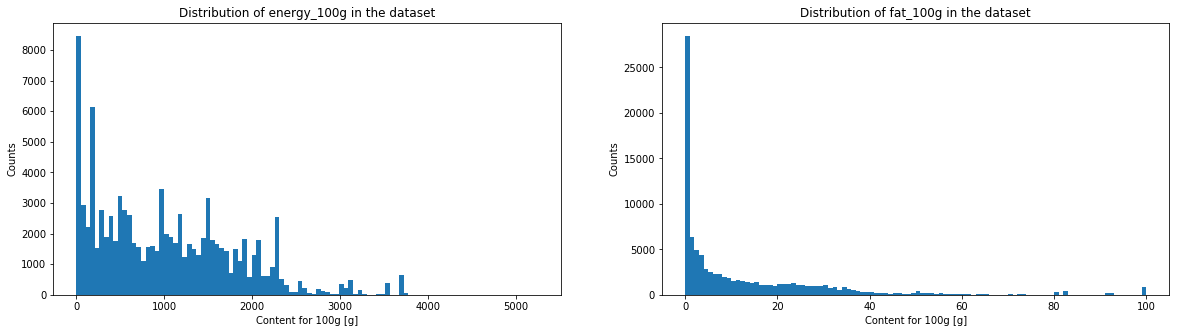

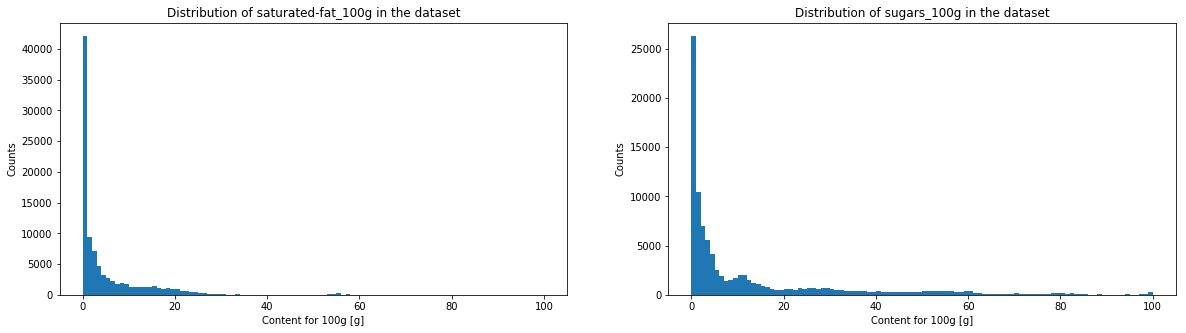

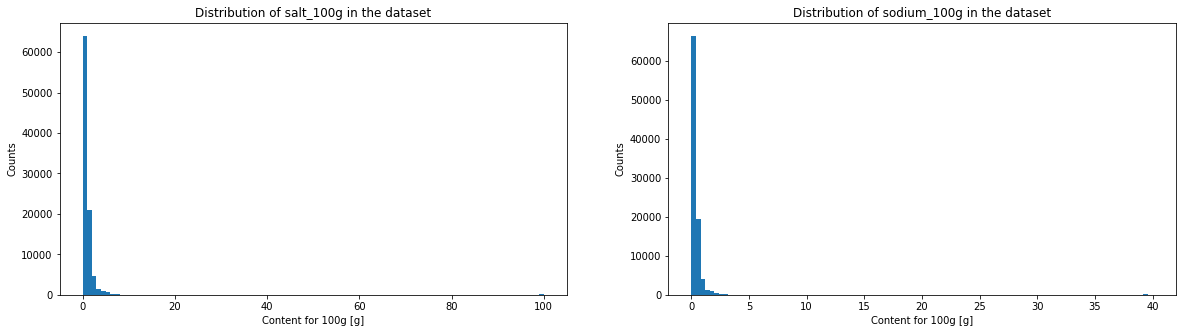

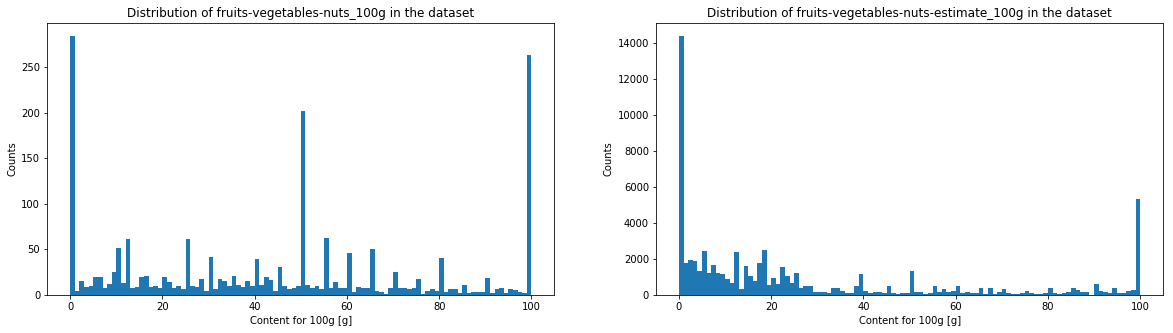

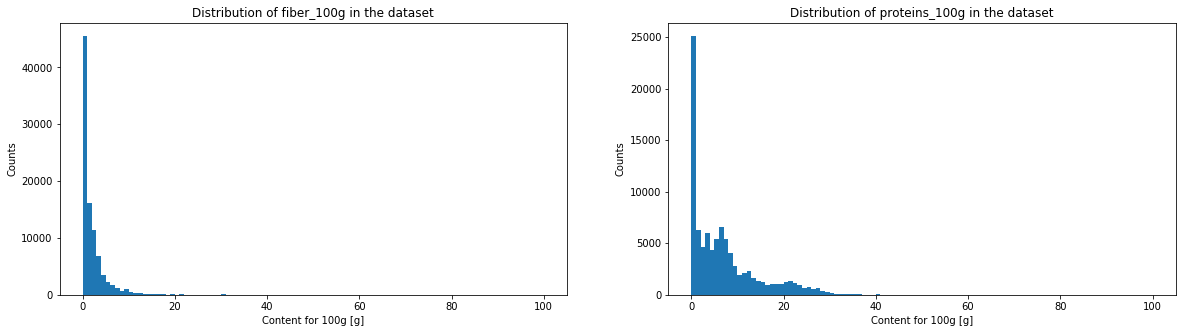

In [72]:
i = 1
for index in range(2, len(data_food_final.columns)):
    column = data_food.columns[index]

    if i > 2:
        i = i - 2
    if i == 1:
        plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, i)
   
    plt.hist(data_food_final[column], bins = 100);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]');
    plt.axis('tight');
    if i == 2:
        plt.show()
    i = i + 1

In [43]:
data_food_final.corr(method ='pearson')

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
energy_100g,1.000000,0.797638,0.607250,0.275852,-0.023445,-0.023571,-0.207856,-0.201694,0.214308,0.242059
fat_100g,0.797638,1.000000,0.743153,-0.083771,0.003472,0.003412,-0.160196,-0.162337,0.045410,0.181348
saturated-fat_100g,0.607250,0.743153,1.000000,-0.000884,-0.001934,-0.001982,-0.243671,-0.218508,-0.008955,0.184520
sugars_100g,0.275852,-0.083771,-0.000884,1.000000,-0.082358,-0.082379,0.044846,0.049532,0.030838,-0.250098
salt_100g,-0.023445,0.003472,-0.001934,-0.082358,1.000000,0.999969,-0.096966,-0.069727,-0.003531,0.066108
sodium_100g,-0.023571,0.003412,-0.001982,-0.082379,0.999969,1.000000,-0.096964,-0.069675,-0.003559,0.066008
fruits-vegetables-nuts_100g,-0.207856,-0.160196,-0.243671,0.044846,-0.096966,-0.096964,1.000000,0.999972,0.100648,-0.218075
fruits-vegetables-nuts-estimate_100g,-0.201694,-0.162337,-0.218508,0.049532,-0.069727,-0.069675,0.999972,1.000000,0.188747,-0.207244
fiber_100g,0.214308,0.045410,-0.008955,0.030838,-0.003531,-0.003559,0.100648,0.188747,1.000000,0.141107
proteins_100g,0.242059,0.181348,0.184520,-0.250098,0.066108,0.066008,-0.218075,-0.207244,0.141107,1.000000


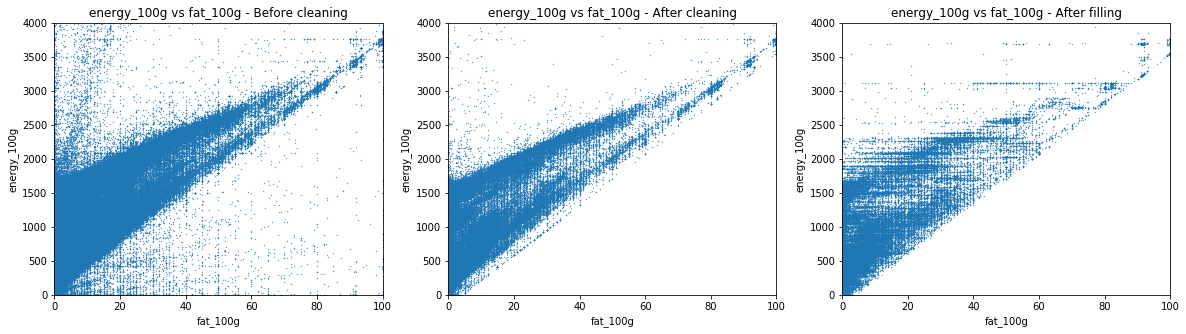

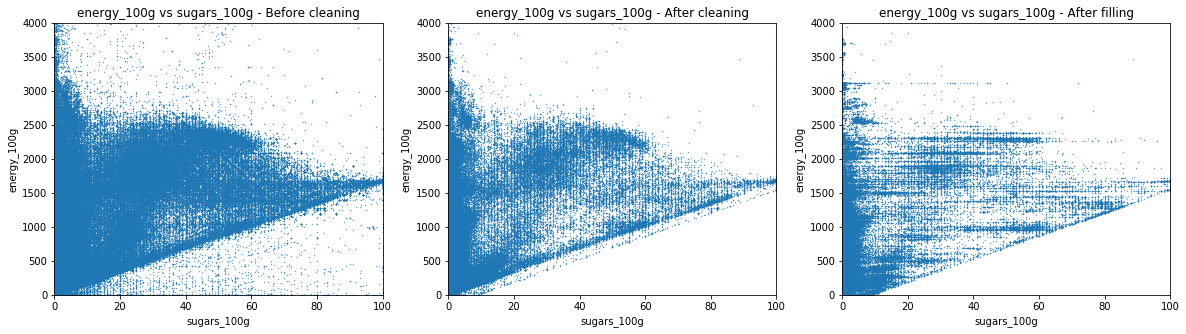

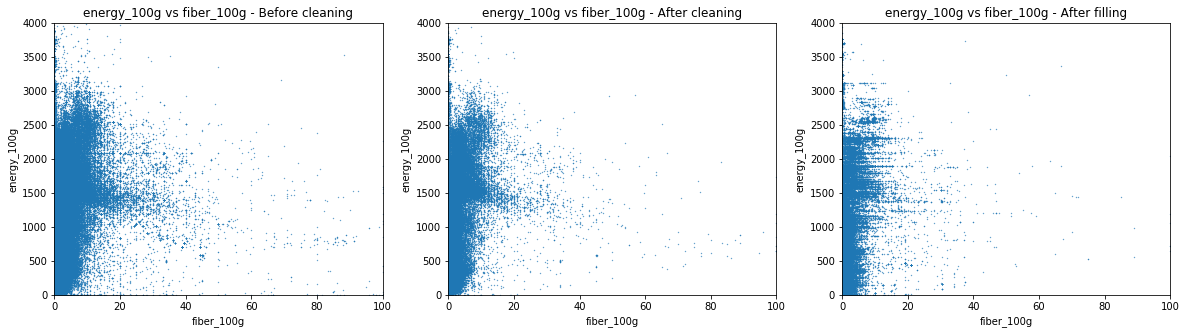

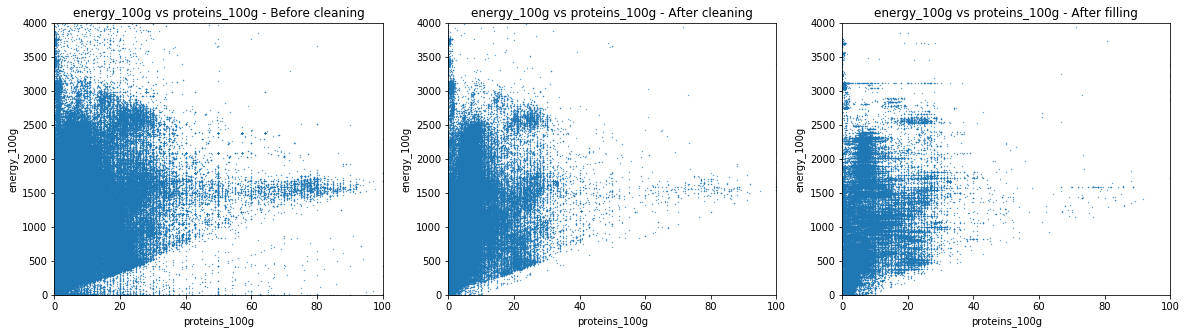

In [53]:
plt_with_energy = [3, 5, 10, 11]

for i_col in range(len(plt_with_energy)):
    x_col = data_food_final.columns[plt_with_energy[i_col]]
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data_raw[x_col],data_raw['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - Before cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);
    
    plt.subplot(1, 3, 2)
    plt.scatter(data_food[x_col],data_food['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);
    

    plt.subplot(1, 3, 3)
    plt.scatter(data_food_final[x_col],data_food_final['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After filling'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);

    plt.show()
    

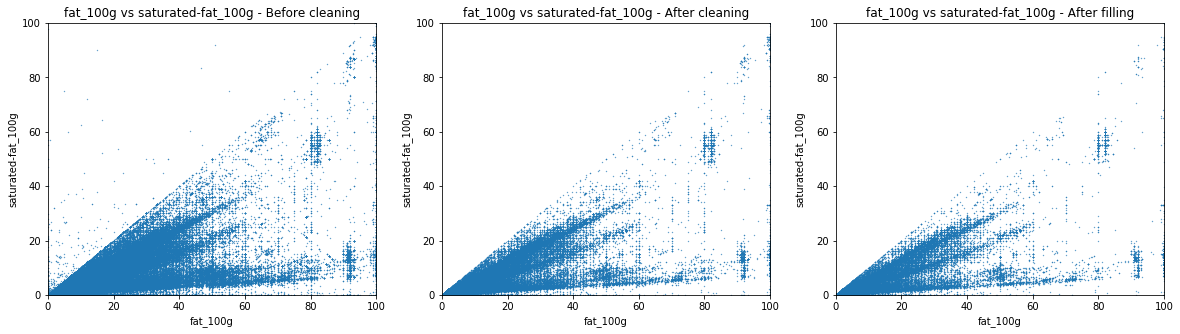

In [55]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['fat_100g'],data_raw['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - Before cleaning');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After cleaning');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['fat_100g'],data_food_final['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After filling');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

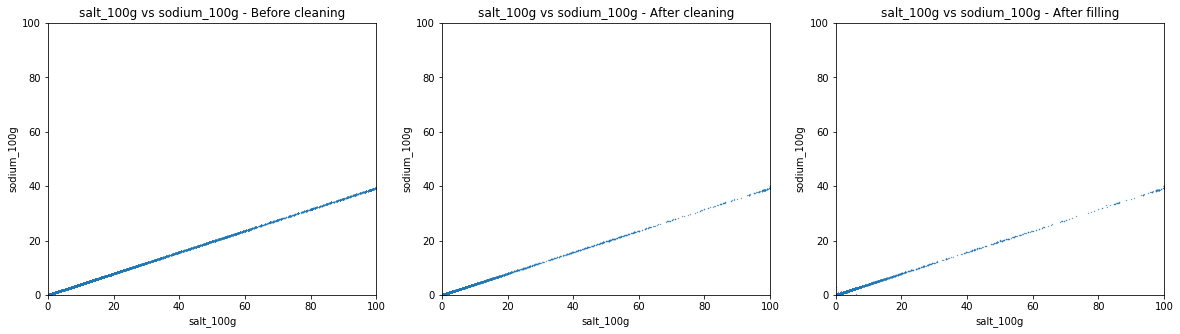

In [56]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['salt_100g'],data_raw['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - Before cleaning');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - After cleaning');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['salt_100g'],data_food_final['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - After filling');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

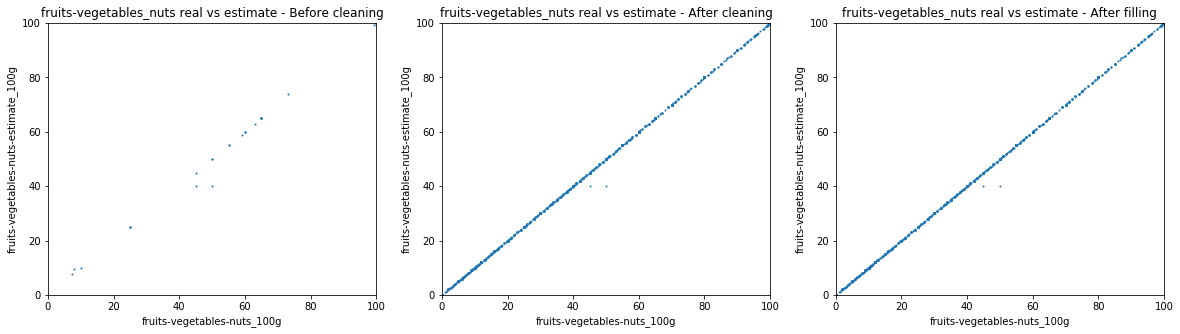

In [57]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['fruits-vegetables-nuts_100g'],data_raw['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - Before cleaning');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food_final['fruits-vegetables-nuts_100g'],data_food_final['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After cleaning');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['fruits-vegetables-nuts_100g'],data_food_final['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After filling');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

In [58]:
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = pd.merge(data_nutriscore,data_food_final, on = 'code' )

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

data_food_nutri_beverages = data_food_nutri[data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False)]
data_food_nutri_non_beverages = data_food_nutri[~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

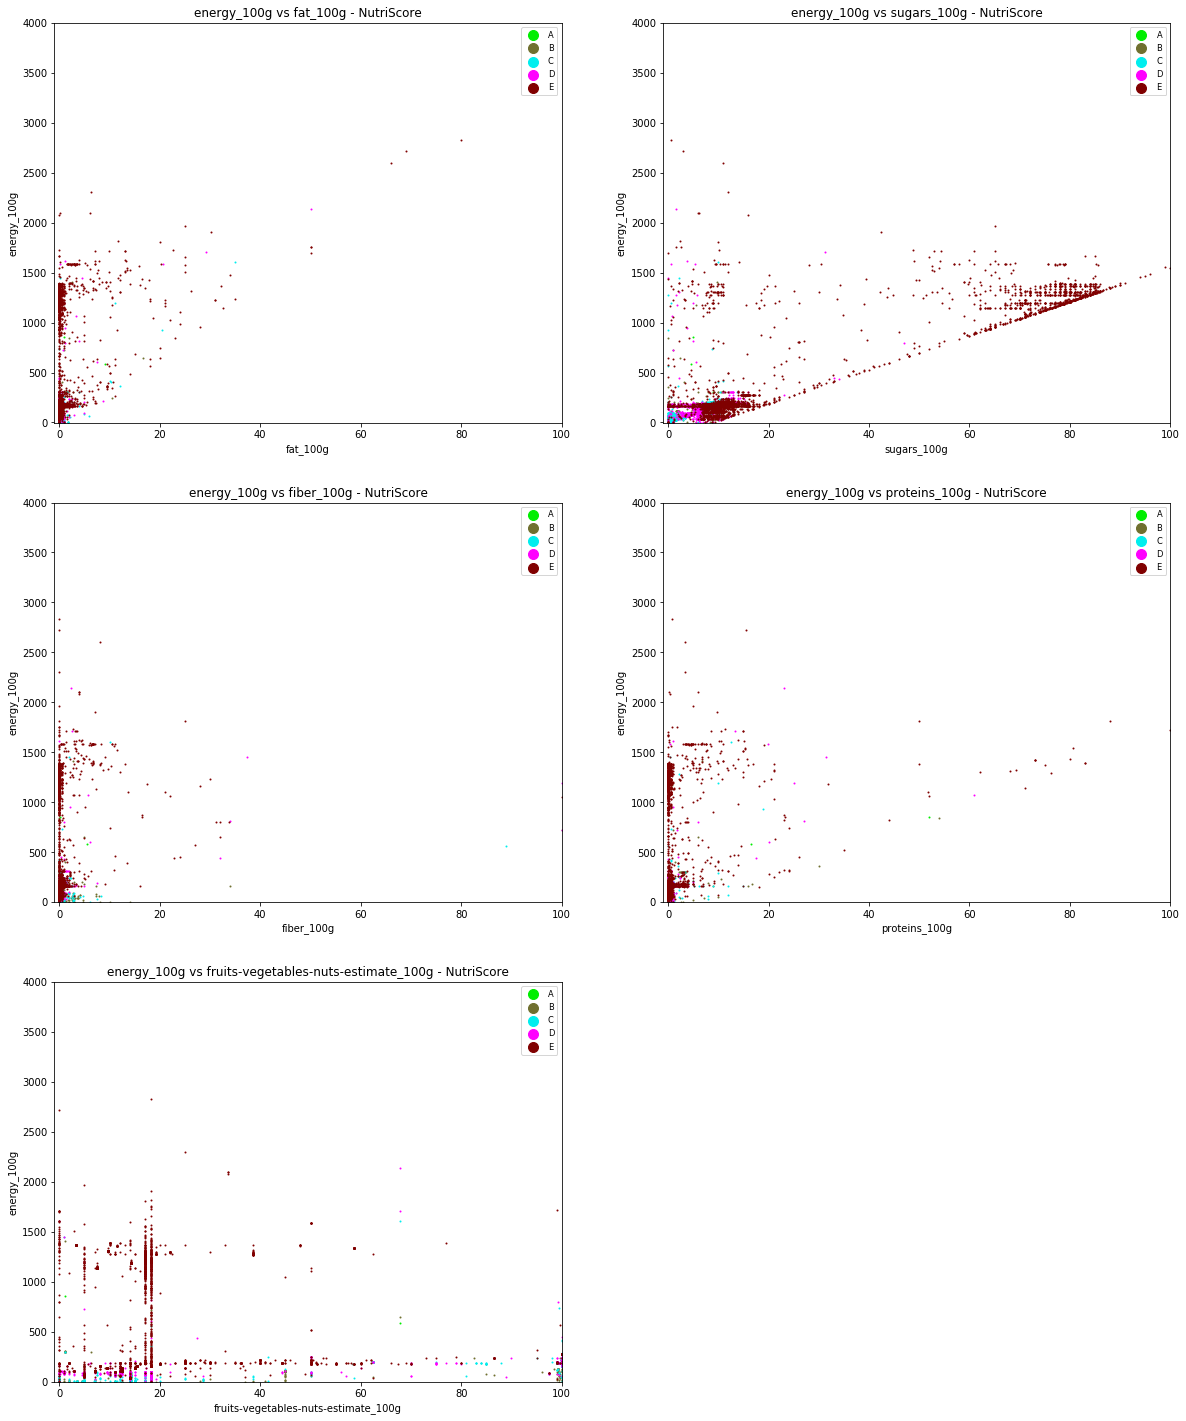

In [65]:
# data_food_nutri_beverages_A = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_beverages_B = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_beverages_C = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_beverages_D = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_beverages_E = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'e']

Color = ['#00ee00','#707030', '#00eeee', '#ff00ff', '#800000']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fat_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fat_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fat_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fat_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fat_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['sugars_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['sugars_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['sugars_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['sugars_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['sugars_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fiber_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fiber_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fiber_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fiber_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fiber_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['proteins_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['proteins_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['proteins_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['proteins_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['proteins_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);


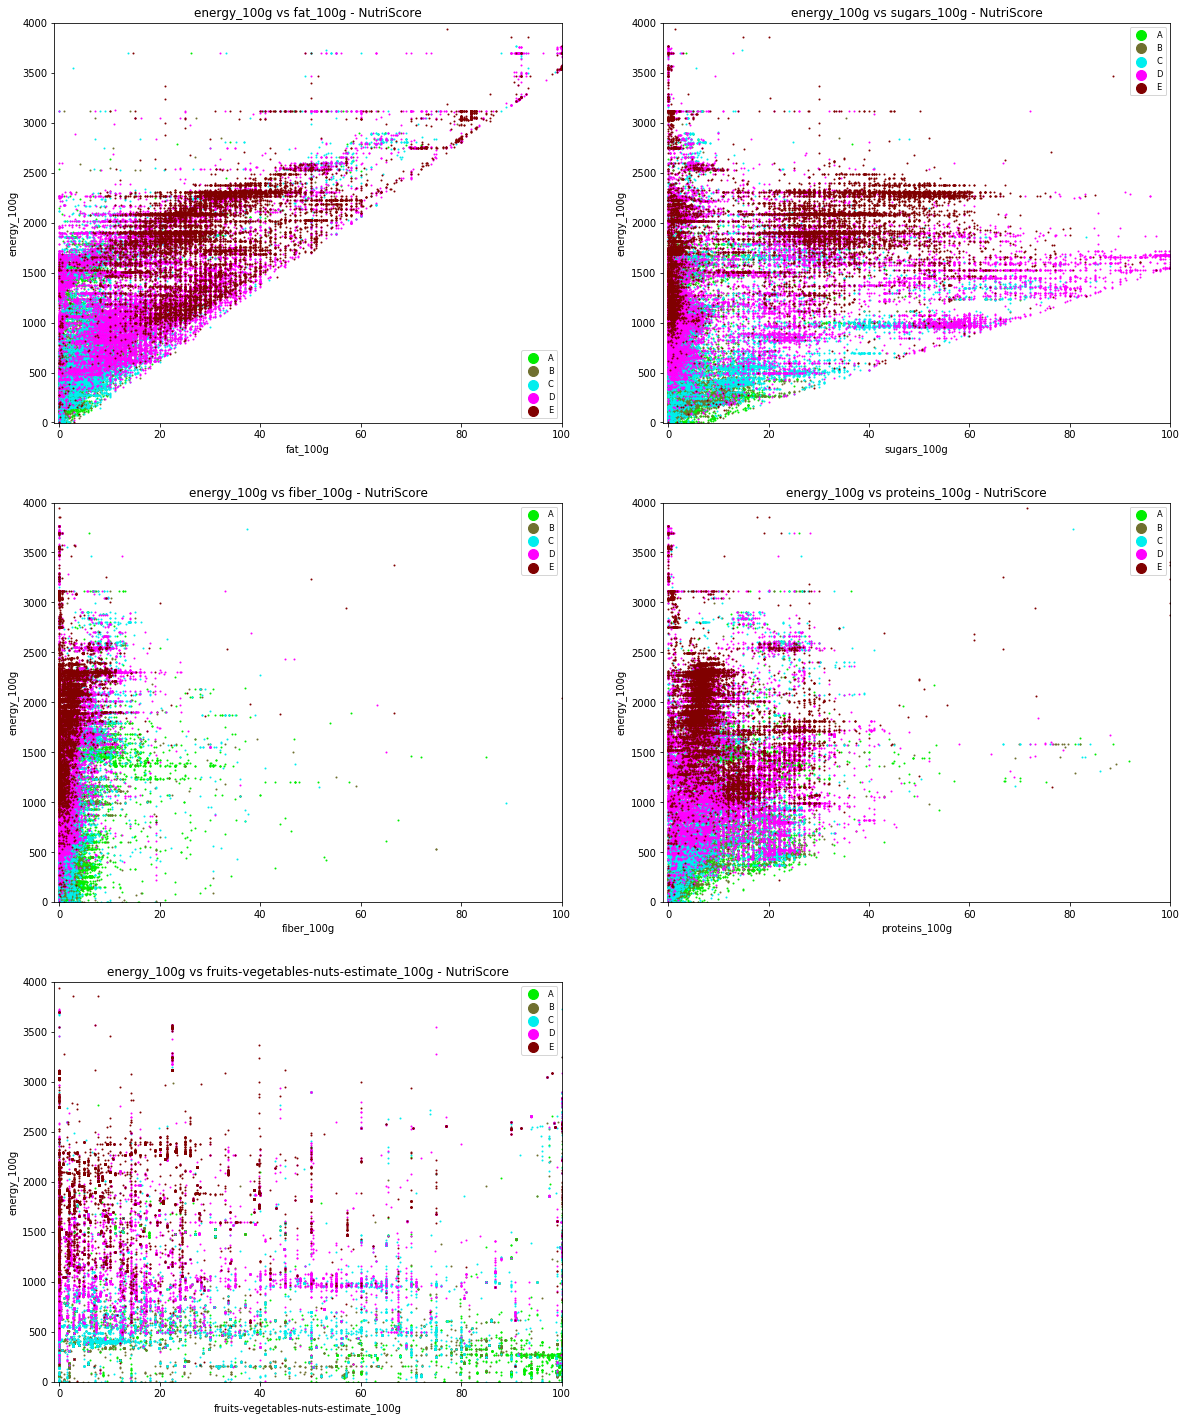

In [66]:
data_food_nutri_non_beverages_A = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_non_beverages_B = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_non_beverages_C = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_non_beverages_D = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_non_beverages_E = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'e']

Color = ['#00ee00','#707030', '#00eeee', '#ff00ff', '#800000']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fat_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fat_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fat_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fat_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fat_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['sugars_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['sugars_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['sugars_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['sugars_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['sugars_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fiber_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fiber_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fiber_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fiber_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fiber_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['proteins_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['proteins_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['proteins_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['proteins_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['proteins_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

### NutriScore - Computation

In [67]:
data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

for index in range(len(data_food_nutri)):

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

In [68]:
y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
labels = ['a', 'b', 'c', 'd', 'e', 'Error']
confusion_matrix_ = confusion_matrix(y_true, y_pred, labels=labels)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index = labels, columns = labels)

,a,b,c,d,e,Error
a,10951,878,71,4,3,93
b,1717,8818,905,32,19,193
c,599,1562,14137,771,52,214
d,86,229,3999,18778,571,420
e,6,22,540,2008,14175,264
Error,0,0,0,0,0,0


In [70]:
data_food_nutri_beverages = data_food_nutri[data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False)]
data_food_nutri_non_beverages = data_food_nutri[~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

print("For Beverages :\n")
ratio_grade = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == data_food_nutri_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_beverages)
ratio_score = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition-score-fr_100g'] == data_food_nutri_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

print("For non-Beverages :\n")
ratio_grade = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == data_food_nutri_non_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_non_beverages)
ratio_score = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition-score-fr_100g'] == data_food_nutri_non_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_non_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

For Beverages :

The accuracy according to the grade is 88.06650246305419 %, the accuracy according to the score is 50.467980295566505 %.

For non-Beverages :

The accuracy according to the grade is 80.68975769287944 %, the accuracy according to the score is 47.90194197062043 %.

